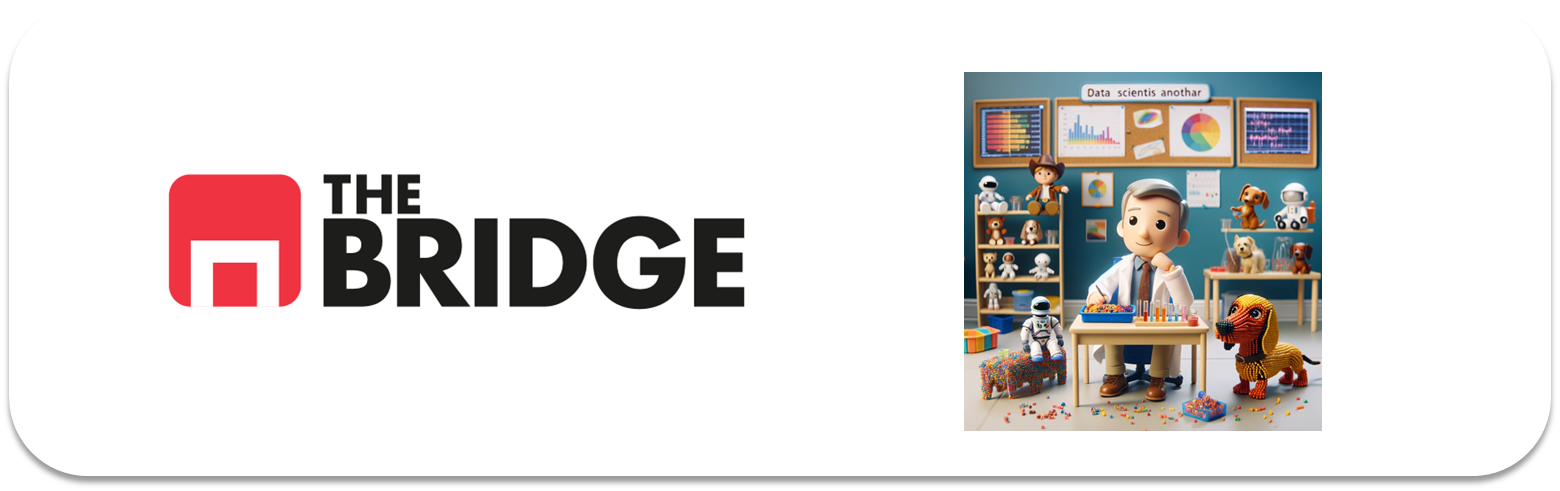

## Análisis de Datos: Outliers

Un outlier es una observación anormal y extrema en un conjunto de valores relacionados, como los de nuestras variables o los de una muestra estadística. Estas anomalías son datos que puede afectar potencialmente a la estimación de los parámetros del mismo.

Se trata de datos que no son consistentes con el resto.

Veamos un ejemplo de cómo afectan los outliers al análisis. Imaginemos que tenemos una muestra con alturas de los alumnos dentro de una clase

In [4]:
alturas = [1.65, 1.80, 1.72, 1.68, 1.75, 1.85, 1.62, 1.79, 1.82, 1.69]

print("Media de alturas:", sum(alturas)/len(alturas))
print("Maximo de alturas:", max(alturas))
print("Minimo de alturas:", min(alturas))

Media de alturas: 1.737
Maximo de alturas: 1.85
Minimo de alturas: 1.62


La altura media cae aproximadamente a mitad del rango (1.735), lo cual tiene sentido al ser una medida de centralidad. Ahora imaginemos que se incorporan a la clase dos futuros NBA.

In [5]:
alturas = [1.65, 1.80, 1.72, 1.68, 1.75, 1.85, 1.62, 1.79, 1.82, 1.69, 2.18, 2.22]

print("Media de alturas:", sum(alturas)/len(alturas))
print("Maximo de alturas:", max(alturas))
print("Minimo de alturas:", min(alturas))

Media de alturas: 1.8141666666666667
Maximo de alturas: 2.22
Minimo de alturas: 1.62


Ahora la media difiere bastante de la mitad del rango (1.92), por lo que nos desvirtúa mucho el cálculo.


Visto el ejemplo, tenemos dos puntos que cubrir:
1. Cómo se detectan.
2. ¿Qué hacer con ellos?

Vayamos por partes y apliquémoslo a nuestros casos de uso... Por eso, sí, acertaste ejecuta estas celdas:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_seguros = pd.read_csv("./data/Marketing-Customer-Analysis.csv")
df_air_jun = pd.read_csv("./data/dataset_viajes_jun23.csv")

In [7]:

def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    

In [8]:

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# plot_histograms_with_density(df, ['columna1', 'columna2', 'columna3'], bins=20)


In [9]:

def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()


### Detección de Outliers

La primera forma de detectar outliers es recurrir a los histogramas y a los diagramas de cajas. Por ejemplo para CLV en nuestro caso de seguros, ya lo vimos:

(2,)


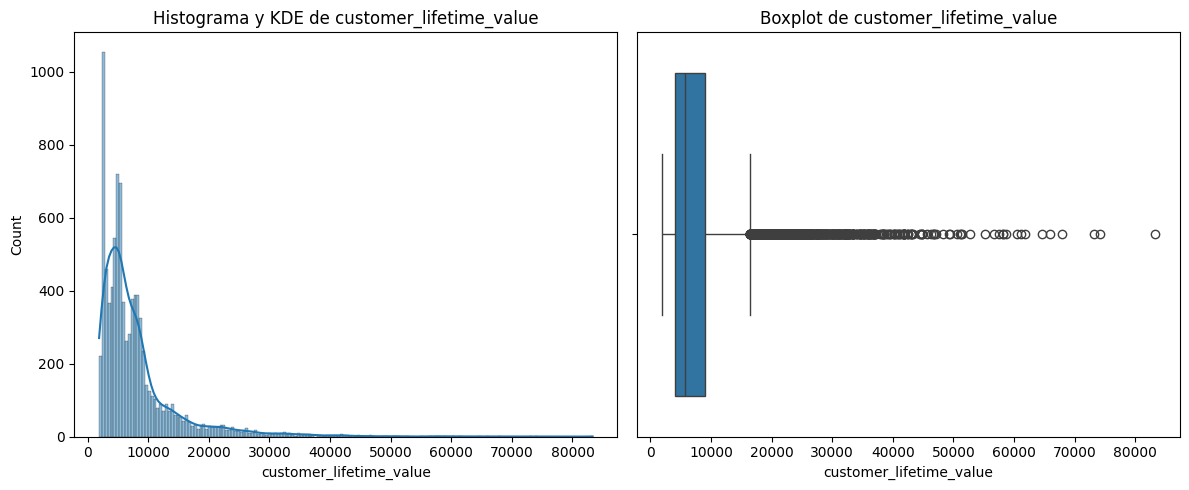

In [10]:
plot_combined_graphs(df_seguros, ["customer_lifetime_value"])

En ambos casos vemos que la larga cola de uno y los valores fuera del "maximum" ya nos indican la presencia de valores anómalos en el rango superior (vamos que se van por la derecha)

Lo que realmente necesitamos es un umbral de corte a partir del cual podamos indicar que lo que es superior o inferior es un valor anómalo. En general este umbral depende de los datos, fíjate que para el diagrama de cajas un punto de corte está por debajo de los 20000 y en el histograma-densidad vemos que podríamos ponerlo más sobre 40000. ¿Cuál coger? ya lo sabes...depende.

1. Cuando la densidad estimada en el diagrama combinado histograma-densidad se parece a una normal, entonces un buen criterio es [y lo explicaremos en la sesión en vivo] obtener la desviación estándar de nuestra variable y considerar outliers a aquellos valores que superen 2 o 3 veces la desviación (valores < media - std\*n) y (valores > media + std\*n) (como puedes ver la distribución normal es simétrica respecto a la media por eso hay que contar a derecha e izquierda). 

|Valor de n | Tanto % de valores comprendidos en el rango no outlier|
|-|-|
|1|68%|
|2|95%|
|3|98%|

2. 


Si se parece a:

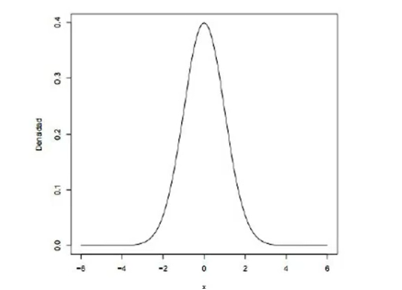


2. Si nuestra densidad no tiene pinta de gaussiana, como le pasa a la distribución de valores de CLV, entonces podemos escoger la longitud de los bigotes de nuestro bloxplot, lo que quede por debajo del "minimum" y por encima del maximum serán outliers. Pero para estos casos te recomiendo que aumentes la longitud de los bigotes en función de lo que veas en el histograma. En plata:


(2,)


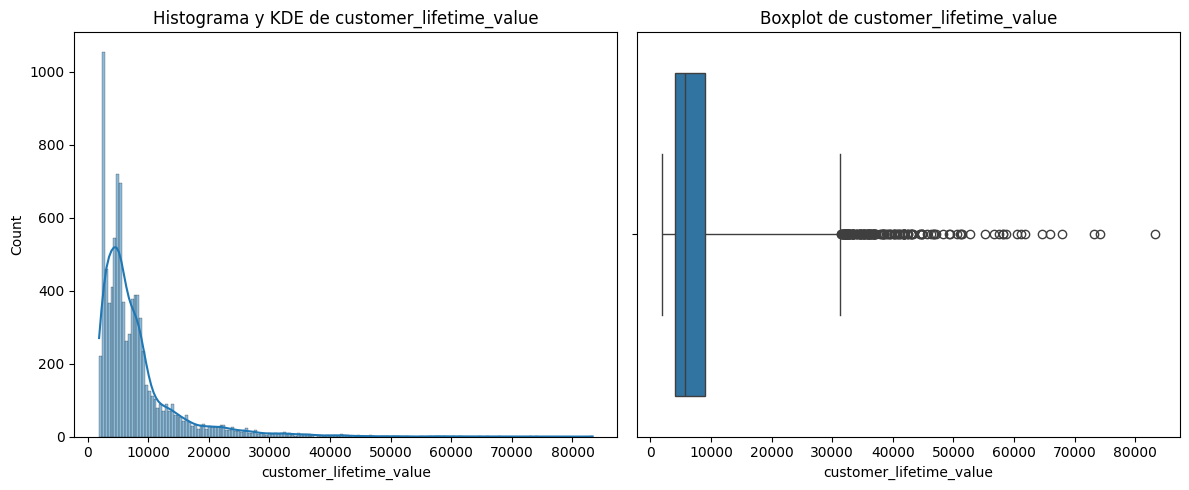

In [11]:
plot_combined_graphs(df_seguros, ["customer_lifetime_value"], whisker_width= 4.5) # 3 veces la longitud habitual (que es 1.5*IQR)

Ahora apliquemos nuestro doble plot a las columnas de los dos datasets para ver que outliers deberíamos tratar:

#### Caso 1.Seguros: Detección de Outliers



(8, 2)


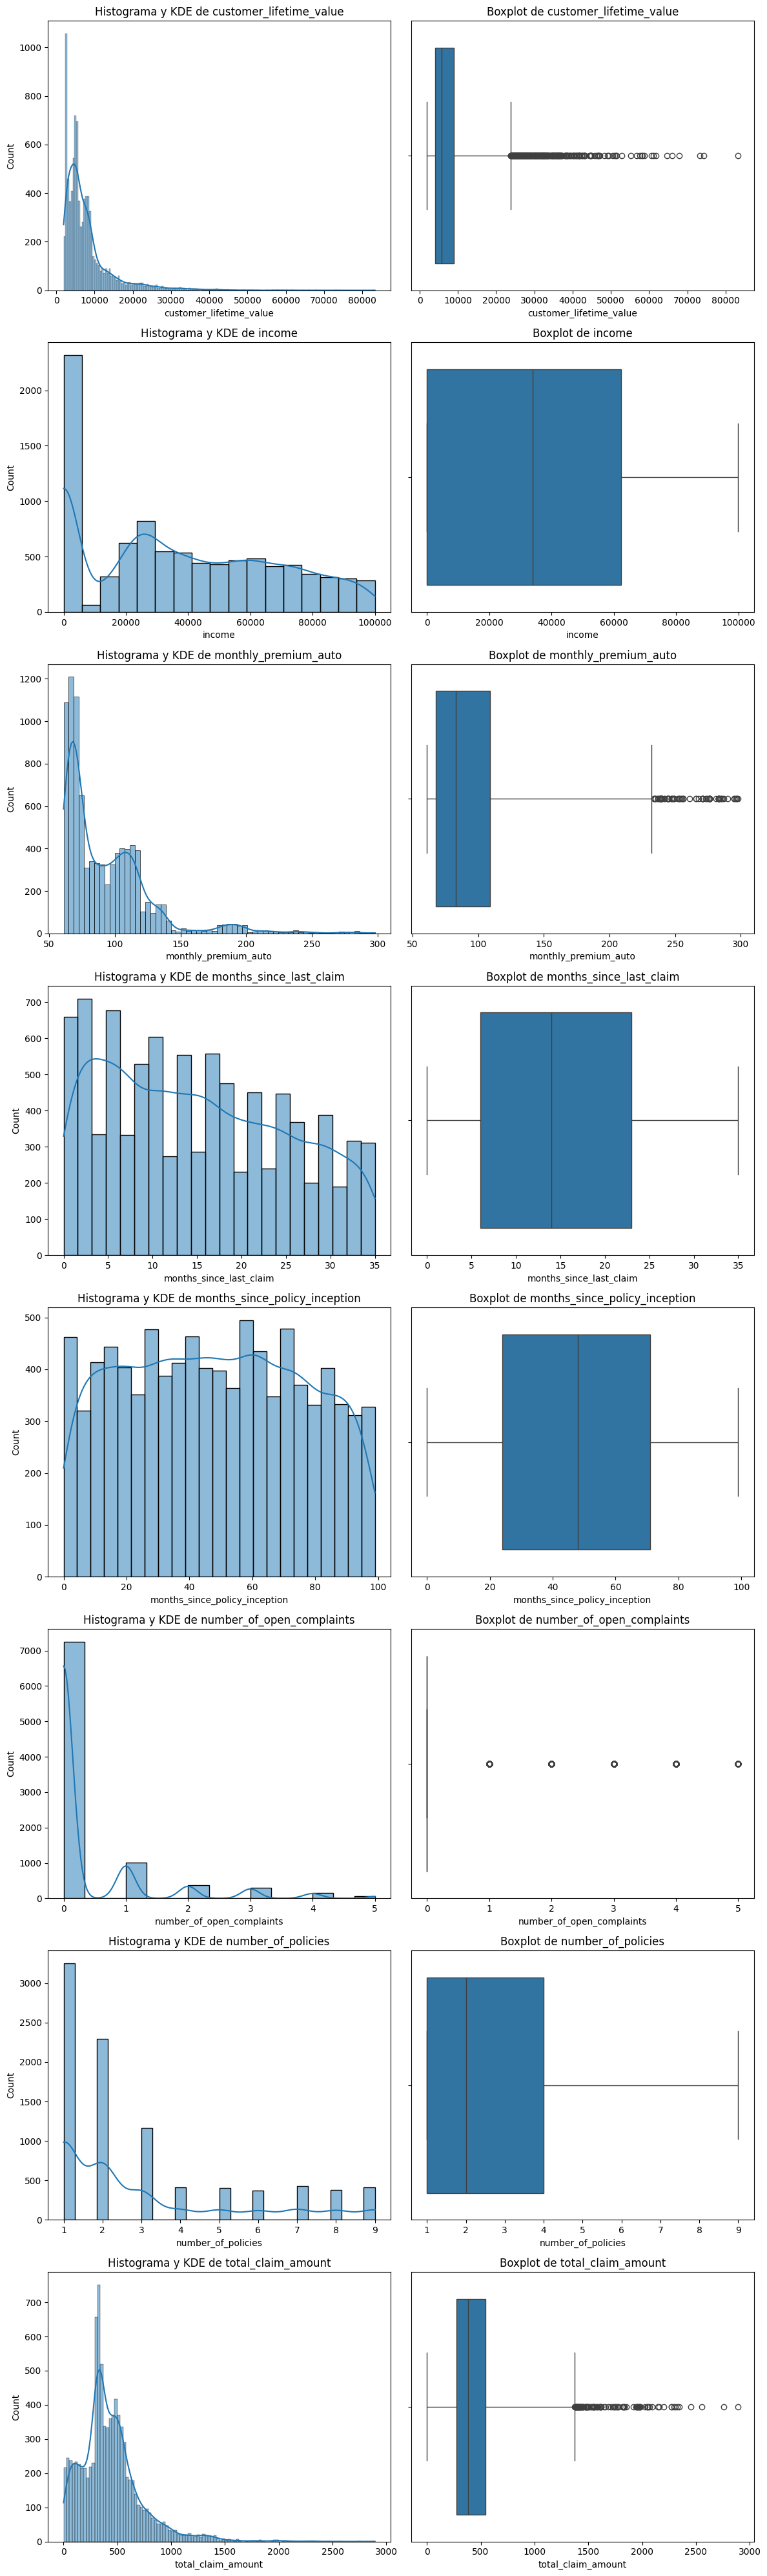

In [12]:
columnas_numericas = df_seguros.describe().columns.to_list()

plot_combined_graphs(df_seguros, columns = columnas_numericas, whisker_width=3)

Hay tres campos o variables claras sobre las que tratar los outliers:
* CLV, que además es prioritaria porque es una de las variables directoras o target.
* Monthly_premium_auto
* Total_claim_amount

Me apuntaría también un análisis que podría ser interesante, ¿coinciden los clientes de los tres outliers? ¿No, por qué?
Y otra cosa curiosa es el diagrama de caja del número de quejas... No me han pedido una análisis pero viendo que tener partes abiertos es un outlier en sí mismo, estudiaría la diferencia entre los clientes con quejas abiertas y sin quejas abiertas.

#### Caso 2. Viajes: Detección de Outliers

(4, 2)


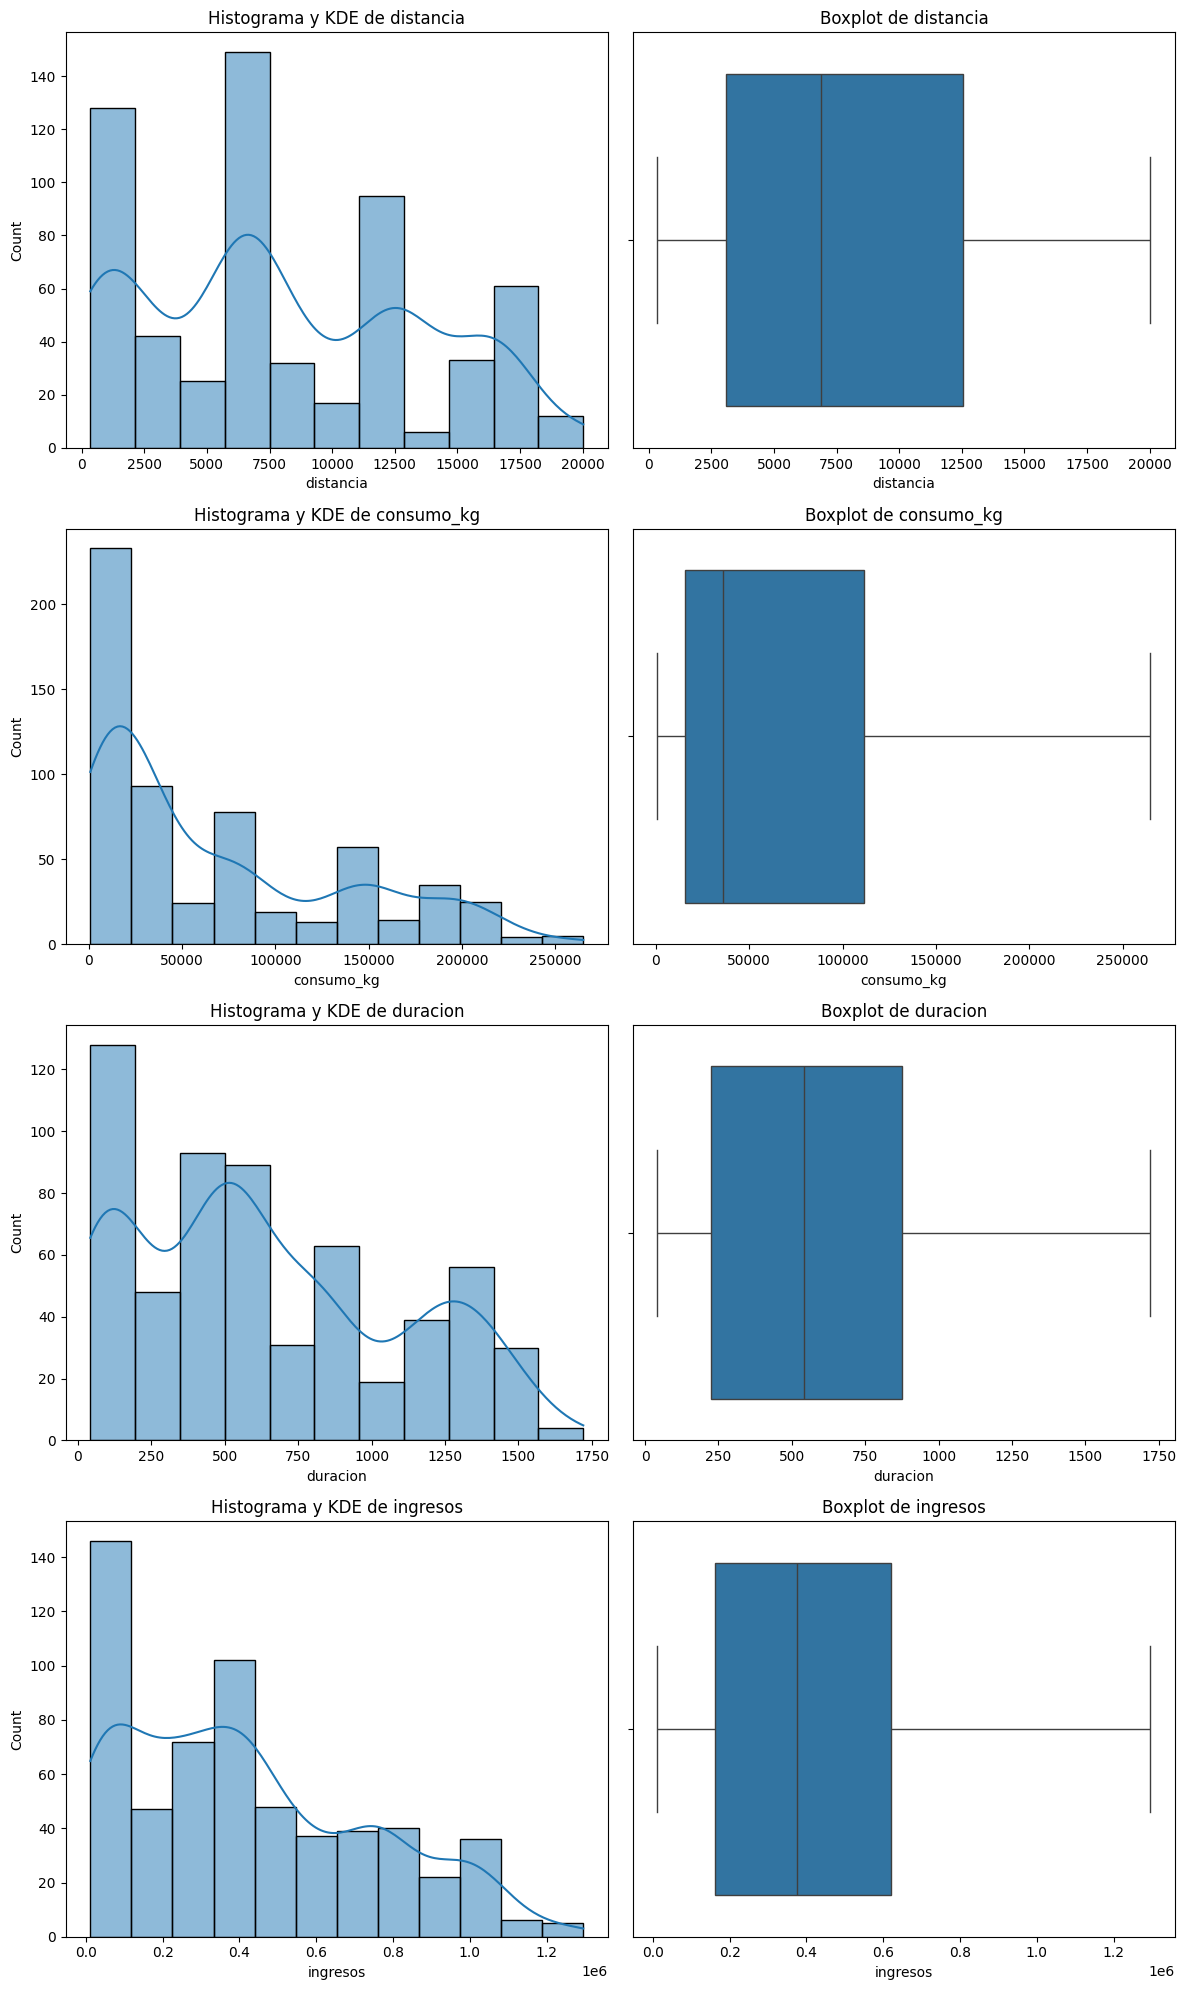

In [13]:
columnas_numericas = df_air_jun.describe().columns.to_list()

plot_combined_graphs(df_air_jun, columns = columnas_numericas, whisker_width= 3)

Así de primeras no hay outliers, y si nos fijamos en los histogramas es cierto que no se ven valores extremos. En este caso, capítulo cerrado.

### Tratamiento de Outliers

Los outliers no son necesariamente malos, de hecho, habrá veces que querrás cazar outliers y que son precisamente esos valores los que te interesan. Por eso qué hacer con ellos depende mucho del problema y el contexto. **No hay una regla para el tratamiento de los mismos**. Un conjunto de posibles tratamientos:

* Mantenerlos 
* Elimiar si son valores erróneos 
* Eliminarlos directamente, indicando que se ha hecho 
* Aplicar transformaciones (se verá en feature engineering). 
* Discretizar la variable 
* Imputar el valor por otro nuevo (como los missings) 
* Tratar por separado 

#### Caso 1. Seguros: Tratamiento de Outliers.

En este caso al ser CLV la variable casi más importante, descartamos eliminarlos, mi sugerencia sería:
1. Asegurarnos de que no son valores erróneos (no tiene pinta)
2. Dividir el dataset en dos, hacer un estudio para unos y otros.
3. Previamente analizar como se relacionan con las otras dos columns de outliers. 

Una vez separados los datasets, analizar los nuevos outliers  (es decir ya en el dataset de outliers de CVL estos ya nos on outliers, pero puede que haya outliers en los otros campos):
1. Categorizar las variables con outliers, rehacer su análisis tal como hicimos con las otras categóricas. 